[*********************100%%**********************]  1 of 1 completed


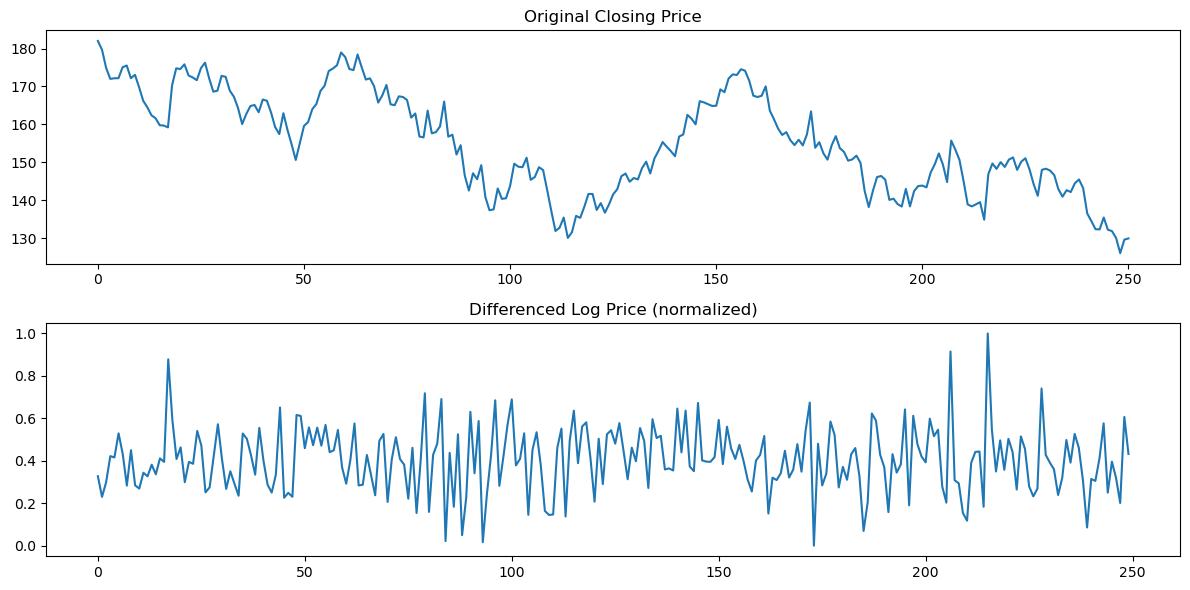

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Data preprocessing
data = yf.download( 'AAPL', start='2022-01-01', end='2023-01-01')
close_data=data['Close'].values.reshape(-1, 1)
def log_diff(data):
    log_data = np.log(data)
    diff_data = np.diff(log_data, axis=0)
    diff_data=diff_data*100
    return diff_data

log_diff_data = log_diff(close_data)
scaler = MinMaxScaler()
log_diff_data  = scaler.fit_transform(log_diff_data )

# Plot close price and log_diff price
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(close_data, label='Closing Price')
plt.title('Original Closing Price')

plt.subplot(212)
plt.plot(log_diff_data , label='Differenced Log Price')
plt.title('Differenced Log Price (normalized)')

plt.tight_layout()
plt.show()

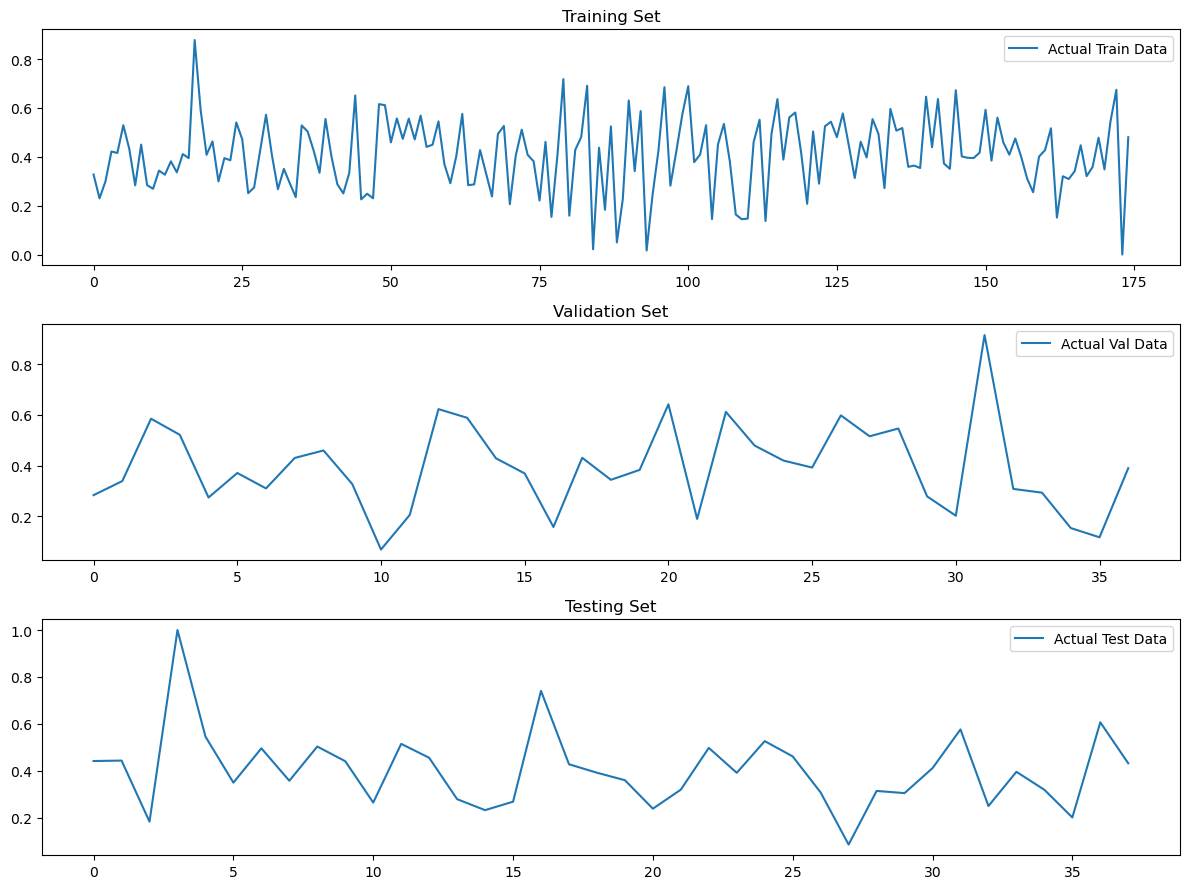

In [2]:
train_size = 0.7
val_size = 0.15

# Split training, validation, and testing sets
def split_data(data, train_size, val_size):
    train_end = int(train_size * len(data))
    val_end = train_end + int(val_size * len(data))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(log_diff_data, train_size, val_size)
plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(train_data, label='Actual Train Data')
plt.title('Training Set')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_data, label='Actual Val Data')
plt.title('Validation Set')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_data, label='Actual Test Data')
plt.title('Testing Set')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Create_rnn_model
def create_rnn_model(time_steps):
    model = Sequential()
    model.add(SimpleRNN(25, activation='tanh', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train_rnn_model
def train_rnn_model(model, train_data,val_data, time_steps,epochs):
    X_train, y_train = [], []
    for i in range(len(train_data) - time_steps):
        X_train.append(train_data[i:i+time_steps])
        y_train.append(train_data[i+time_steps])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = [], []
    for i in range(len(val_data) - time_steps):
        X_val.append(val_data[i:i+time_steps])
        y_val.append(val_data[i+time_steps])
    X_val, y_val = np.array(X_val), np.array(y_val)
    history =model.fit(X_train, y_train, epochs=epochs,validation_data=(X_val, y_val),batch_size=11, verbose=0)
    return history

# Predict_and_evaluate
def predict_and_evaluate(model, data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])

    X, y = np.array(X), np.array(y)
    y_pred = model.predict(X)
   # y_pred = scaler.inverse_transform(y_pred)
   # y= scaler.inverse_transform(y)
    mse = mean_squared_error(y, y_pred)
    return y_pred,mse

# Visualization of results
def plot_results(train_data, test_data, y_train_pred, y_test_pred):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(train_data, label='Actual Train Data')
    plt.plot(np.arange(time_steps, len(train_data)), y_train_pred, label='Predicted Train Data')
    plt.title('Training Set')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(test_data, label='Actual Test Data')
    plt.plot(np.arange(time_steps, len(test_data)), y_test_pred, label='Predicted Test Data')
    plt.title('Testing Set')
    plt.legend()

    plt.tight_layout()
    plt.show()


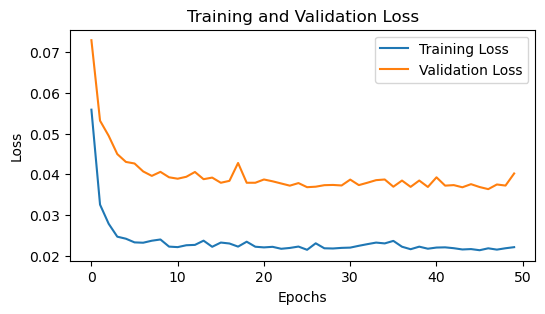

1/1 [==============================] - 0s 20ms/step
Test Mean Squared Error: 0.029116626184410722
Test Root Mean Squared Error: 0.17063594634311588
Test Mean Absolute Error: 0.14071190477659148
Test Mean Absolute Percentage Error: 55.96%


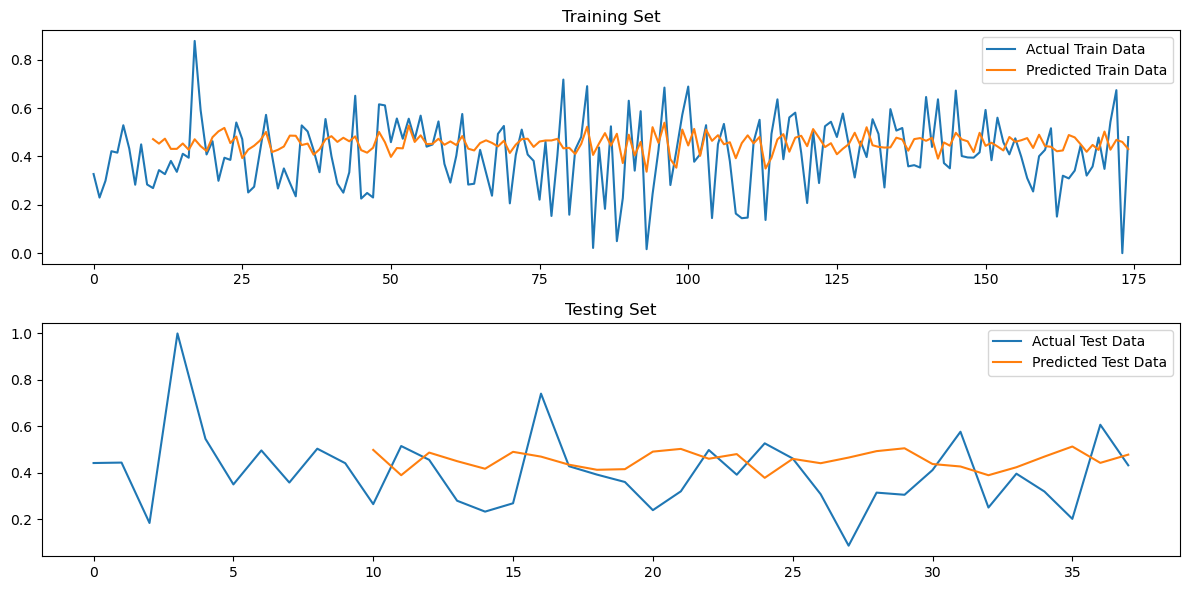

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


# Create and train RNN model,record training history
time_steps = 10
epochs=50
model = create_rnn_model(time_steps)
history = train_rnn_model(model, train_data, val_data,time_steps,epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot trainning and validation loss
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model performance
y_train_pred,mse_train = predict_and_evaluate(model, train_data, time_steps)
y_test_pred,mse_test= predict_and_evaluate(model, test_data, time_steps)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data[time_steps:], y_test_pred)
mape_test = np.mean(np.abs((test_data[time_steps:] - y_test_pred) / test_data[time_steps:])) * 100

# 打印其他评估指标
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Root Mean Squared Error: {rmse_test}")
print(f"Test Mean Absolute Error: {mae_test}")
print(f"Test Mean Absolute Percentage Error: {mape_test:.2f}%")
# Visualization of results
plot_results(train_data, test_data, y_train_pred, y_test_pred)

C:\Windows\Temp\ipykernel_10008\2769264451.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_for_grid_search = KerasRegressor(build_fn=rnn_model_for_grid_search, epochs=20, batch_size=10, verbose=0)


Best Parameters:  {'activation': 'relu', 'units': 75}
1/1 [==============================] - 0s 21ms/step
Test Mean Squared Error: 0.022006425884550037
Test Root Mean Squared Error: 0.1483456298127789
Test Mean Absolute Error: 0.11555026059975906
Test Mean Absolute Percentage Error: 41.61%


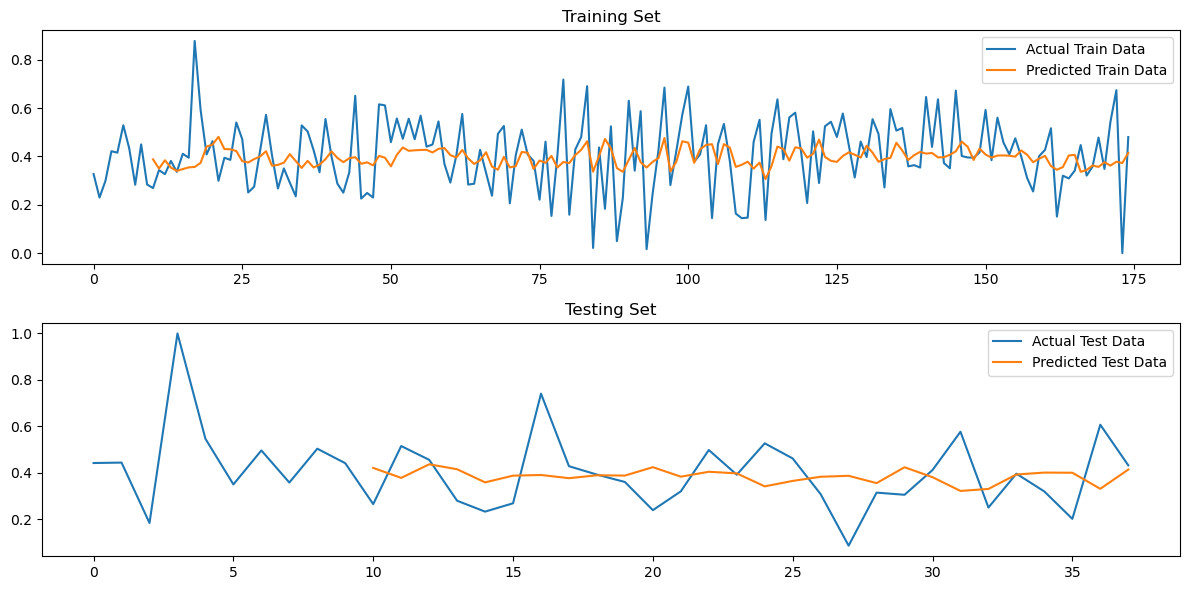

In [15]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# rnn_model_for_grid_search
def rnn_model_for_grid_search(units, activation='relu'):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(time_steps, 1)))
    model.add(Dense(1,activation ='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model
model_for_grid_search = KerasRegressor(build_fn=rnn_model_for_grid_search, epochs=20, batch_size=10, verbose=0)

#Set parameters
param_grid = {
    'units': [ 50, 75,128],
    'activation': ['relu', 'tanh']
}

#Grid search
grid_search = GridSearchCV(estimator=model_for_grid_search, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
train_data, val_data, test_data = split_data(log_diff_data, train_size, val_size)
X_train, y_train = [], []
for i in range(len(train_data) - time_steps):
    X_train.append(train_data[i:i+time_steps])
    y_train.append(train_data[i+time_steps])
X_train, y_train = np.array(X_train), np.array(y_train)
grid_result = grid_search.fit(X_train, y_train)

#Print Best Parameters
print("Best Parameters: ", grid_result.best_params_)
best_model = grid_result.best_estimator_.model

# Evaluate model performance
y_train_pred, mse_train = predict_and_evaluate(best_model, train_data, time_steps)
y_test_pred, mse_test = predict_and_evaluate(best_model, test_data, time_steps)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data[time_steps:], y_test_pred)
mape_test = np.mean(np.abs((test_data[time_steps:] - y_test_pred) / test_data[time_steps:])) * 100

print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Root Mean Squared Error: {rmse_test}")
print(f"Test Mean Absolute Error: {mae_test}")
print(f"Test Mean Absolute Percentage Error: {mape_test:.2f}%")

# Visualization of results
plot_results(train_data, test_data, y_train_pred, y_test_pred)


1/1 [==============================] - 0s 23ms/step
LSTM Train Mean Squared Error: 0.02311029482282275
LSTM Test Mean Squared Error: 0.018681371820557704
LSTM Test Root Mean Squared Error: 0.13667981497118623
LSTM Test Mean Absolute Error: 0.10634860334602327
LSTM Test Mean Absolute Percentage Error: 39.15%


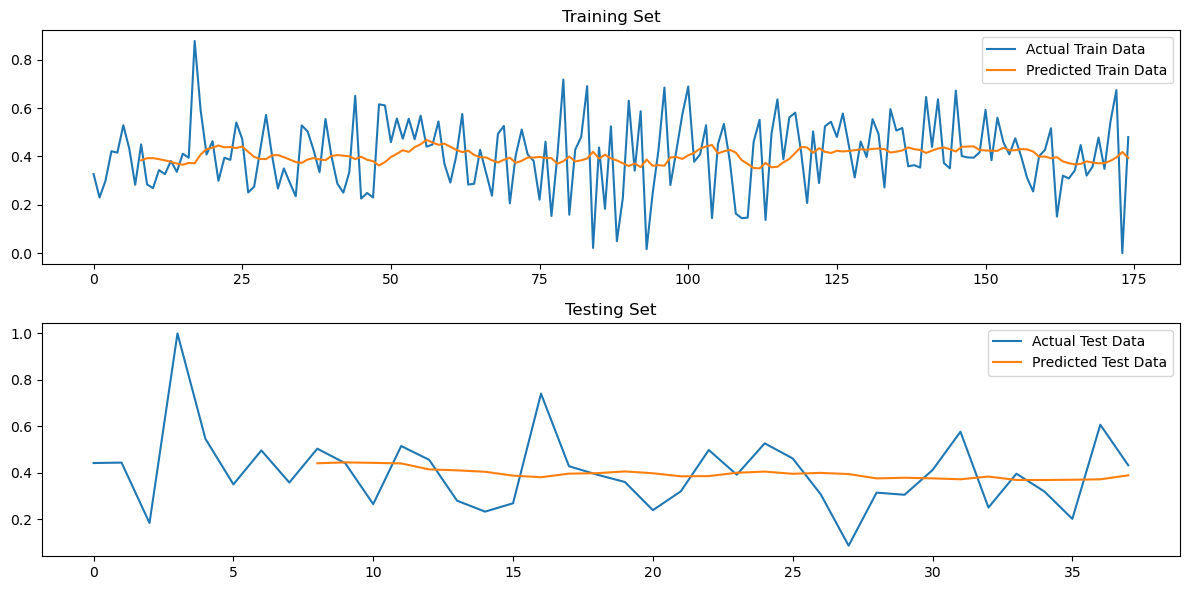

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def create_lstm_model(time_steps):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_lstm_model(model, train_data, time_steps, epochs):
    X_train, y_train = [], []
    for i in range(len(train_data) - time_steps):
        X_train.append(train_data[i:i+time_steps])
        y_train.append(train_data[i+time_steps])

    X_train, y_train = np.array(X_train), np.array(y_train)

    model.fit(X_train, y_train, epochs=30, verbose=0)

def predict_and_evaluate_lstm(model, data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])

    X, y = np.array(X), np.array(y)
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    return y_pred, mse


def plot_results_lstm(train_data, test_data, y_train_pred, y_test_pred):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(train_data, label='Actual Train Data')
    plt.plot(np.arange(time_steps, len(train_data)), y_train_pred, label='Predicted Train Data')
    plt.title('Training Set')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(test_data, label='Actual Test Data')
    plt.plot(np.arange(time_steps, len(test_data)), y_test_pred, label='Predicted Test Data')
    plt.title('Testing Set')
    plt.legend()

    plt.tight_layout()
    plt.show()

time_steps = 8
epochs =20
lstm_model = create_lstm_model(time_steps)
train_lstm_model(lstm_model, train_data, time_steps, epochs)

# Evaluate
y_train_pred_lstm, mse_train_lstm = predict_and_evaluate_lstm(lstm_model, train_data, time_steps)
y_test_pred_lstm, mse_test_lstm = predict_and_evaluate_lstm(lstm_model, test_data, time_steps)

rmse_test_lstm = np.sqrt(mse_test_lstm)
mae_test_lstm = mean_absolute_error(test_data[time_steps:], y_test_pred_lstm)
mape_test_lstm = np.mean(np.abs((test_data[time_steps:] - y_test_pred_lstm) / test_data[time_steps:])) * 100
print(f"LSTM Train Mean Squared Error: {mse_train_lstm}")
print(f"LSTM Test Mean Squared Error: {mse_test_lstm}")
print(f"LSTM Test Root Mean Squared Error: {rmse_test_lstm}")
print(f"LSTM Test Mean Absolute Error: {mae_test_lstm}")
print(f"LSTM Test Mean Absolute Percentage Error: {mape_test_lstm:.2f}%")
# Visualization of results
plot_results_lstm(train_data, test_data, y_train_pred_lstm, y_test_pred_lstm)
